# CASE STUDY: PRODUCTION / MAINTENANCE DEPARTMENT

## Key Learning Outcomes:
- Learn how to leverage the power of data science to improve the production process and conduct predictive maintenance.
- Build and train a segmentation model to localize detects in images.
- Build and train Residual UNet mode.
- Access trained detection and segmentation models performance.
- Develop a two layered detection networks using ResNet-50 and UNet to detect and classify defects in production environment.
___
- **Production + Segmentation + UNET/RESNET + Two layered detection + Localization**
___

### TASK-1: UNDERSTAND THE PROBLEM STATEMENT AND BUSINESS CASE

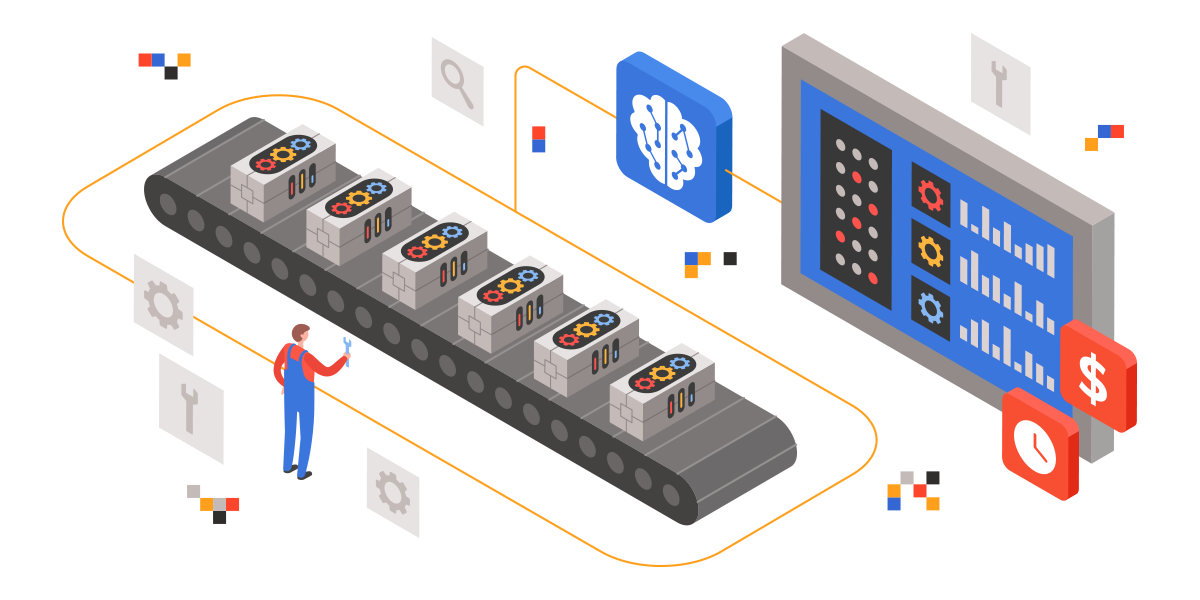

<center>
    <b>Figure1. Predict Defects Using Deep Learning</b>
</center>

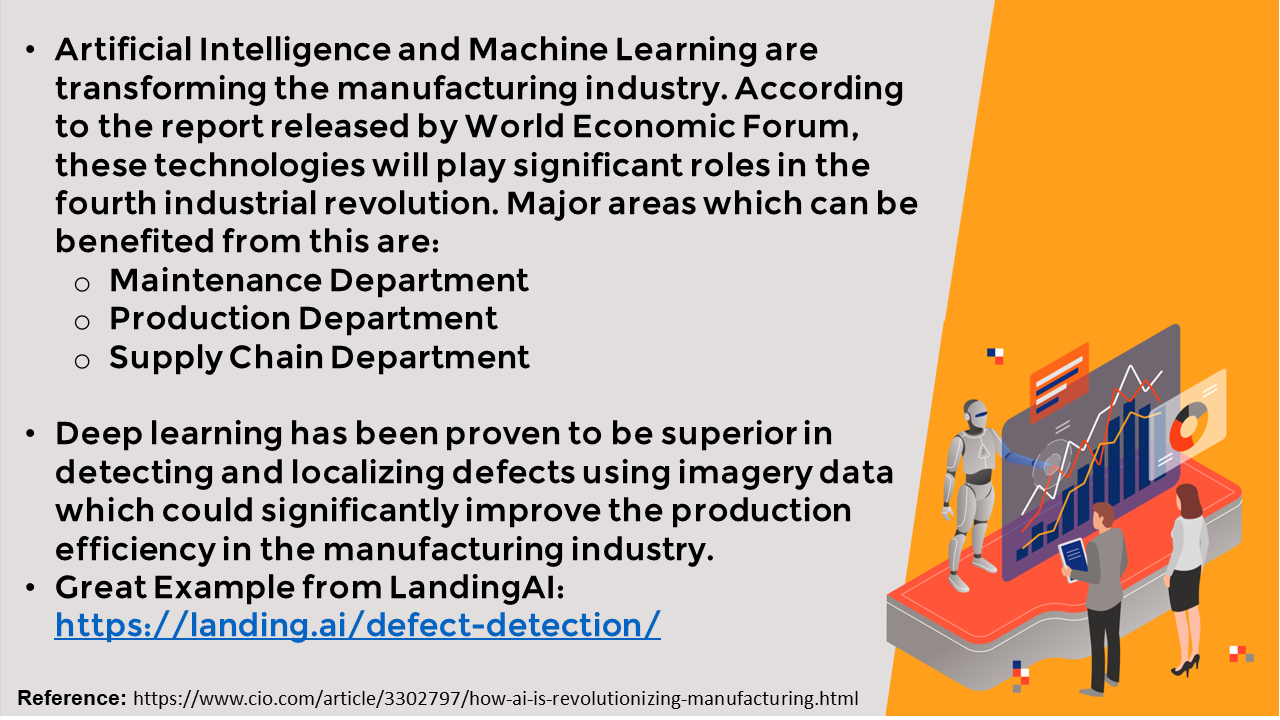

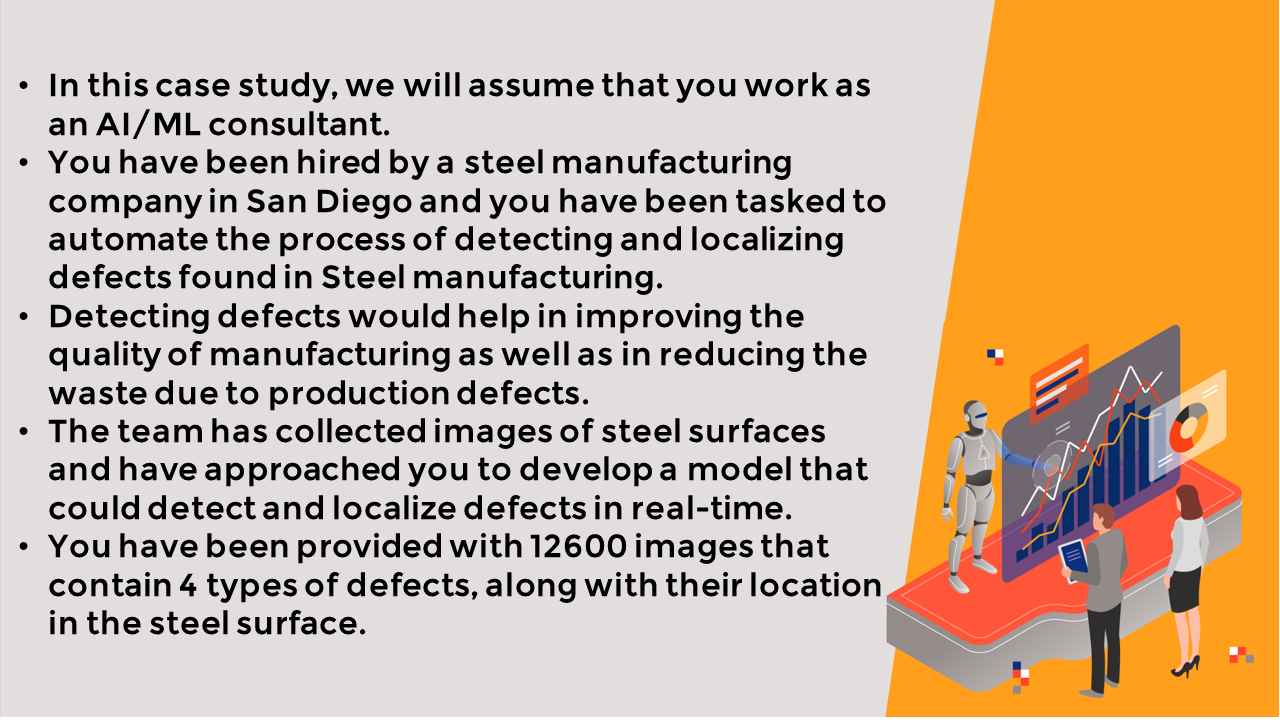

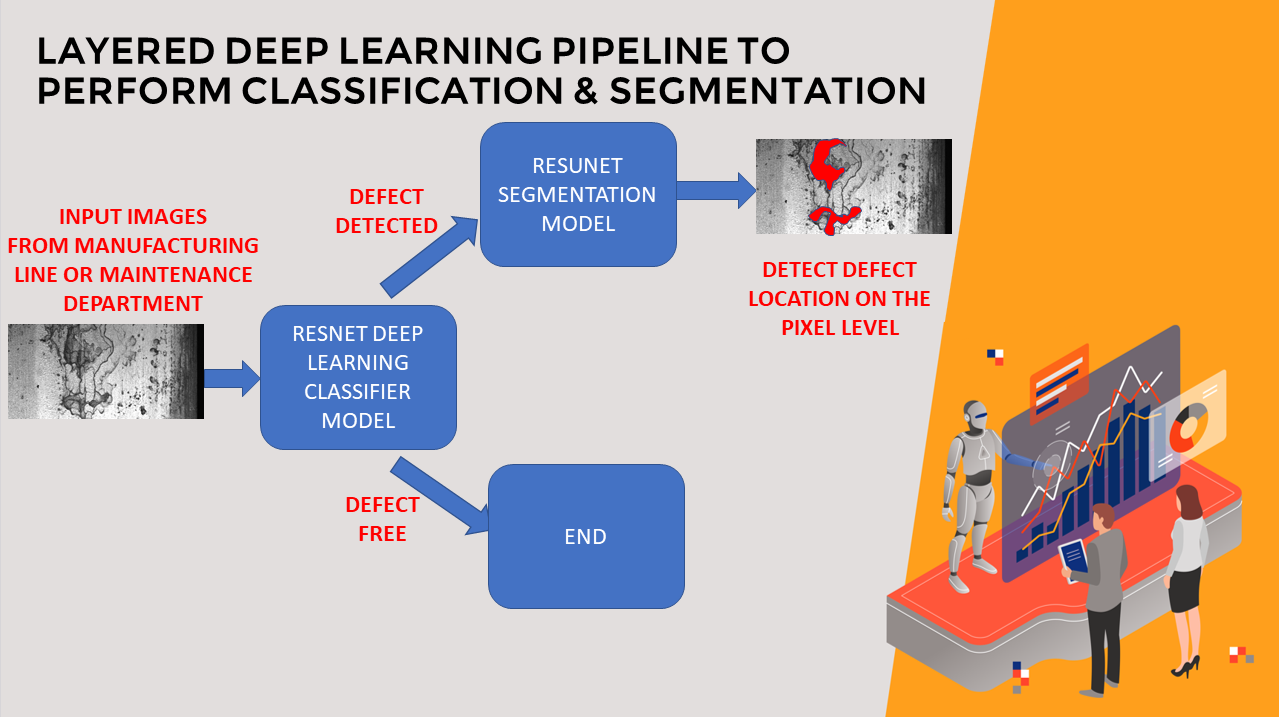

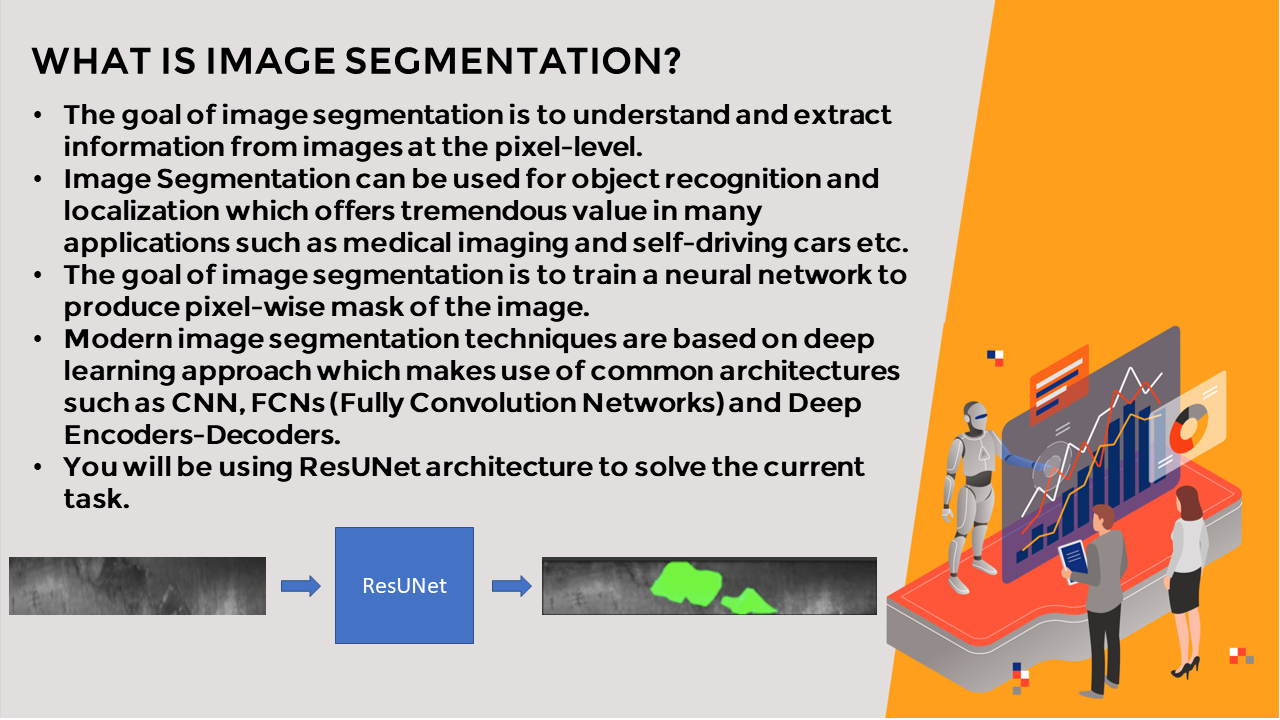

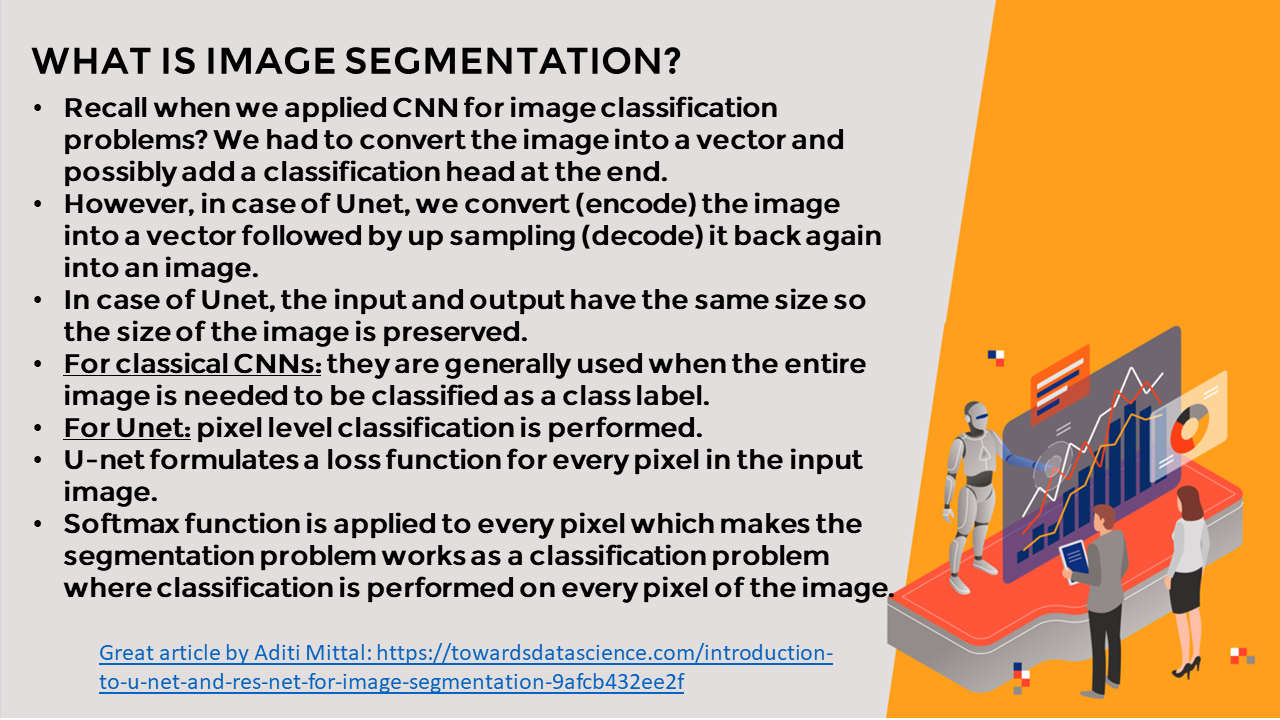

### TASK-2: IMPORT LIBRARIES AND DATASETS

In [1]:
#pip install numpy==1.26.4  # we are using this version of numpy due to some libraries compatibility issues
# pip install scikit-image

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import zipfile
import cv2
from skimage import io          # link: https://scikit-image.org/docs/stable/api/skimage.html
import tensorflow as tf
from tensorflow.python.keras import Sequential
from tensorflow.keras import layers, optimizers
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.initializers import glorot_uniform
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint, LearningRateScheduler
from IPython.display import display
from tensorflow.keras import backend as K
from sklearn.preprocessing import StandardScaler, normalize
import os
import sys
# from google.colab import files 
%matplotlib inline

In [3]:
# we need to mount our drive using the following commands:
# For more information regarding mounting, please check this out: https://stackoverflow.com/questions/46986398/import-data-into-google-colaboratory

# from google.colab import drive
# drive.mount('/content/drive')

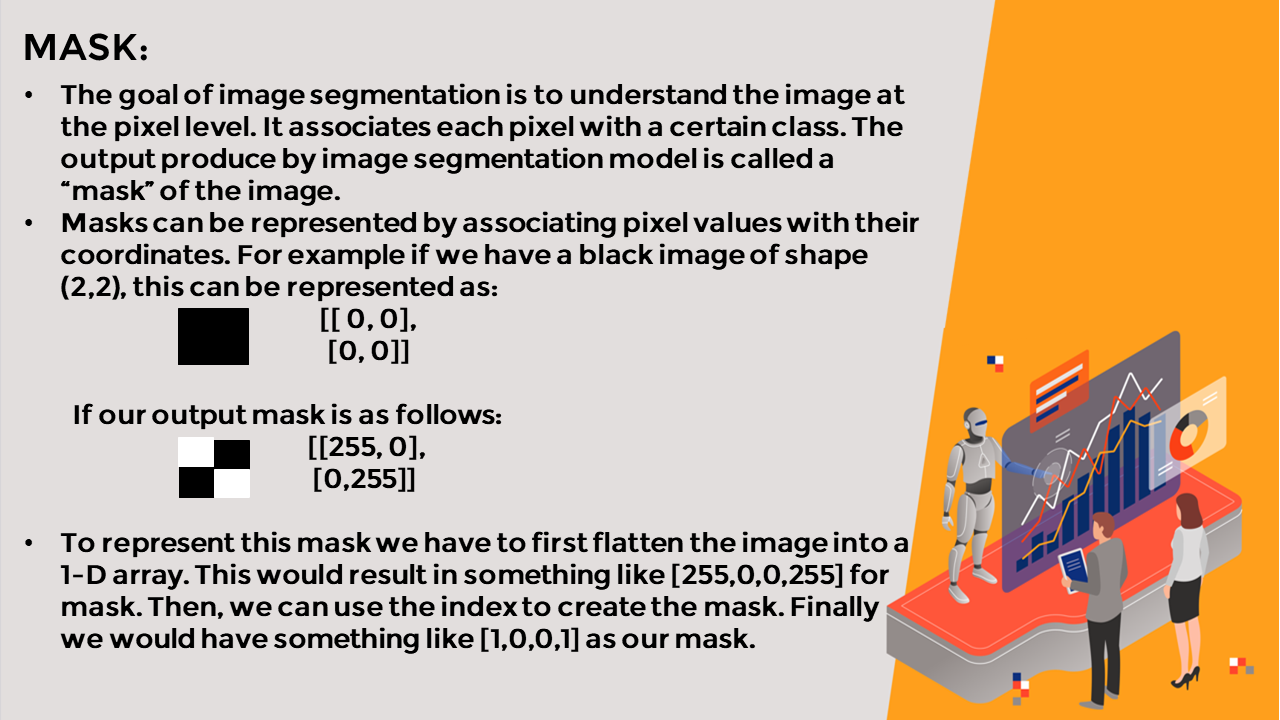

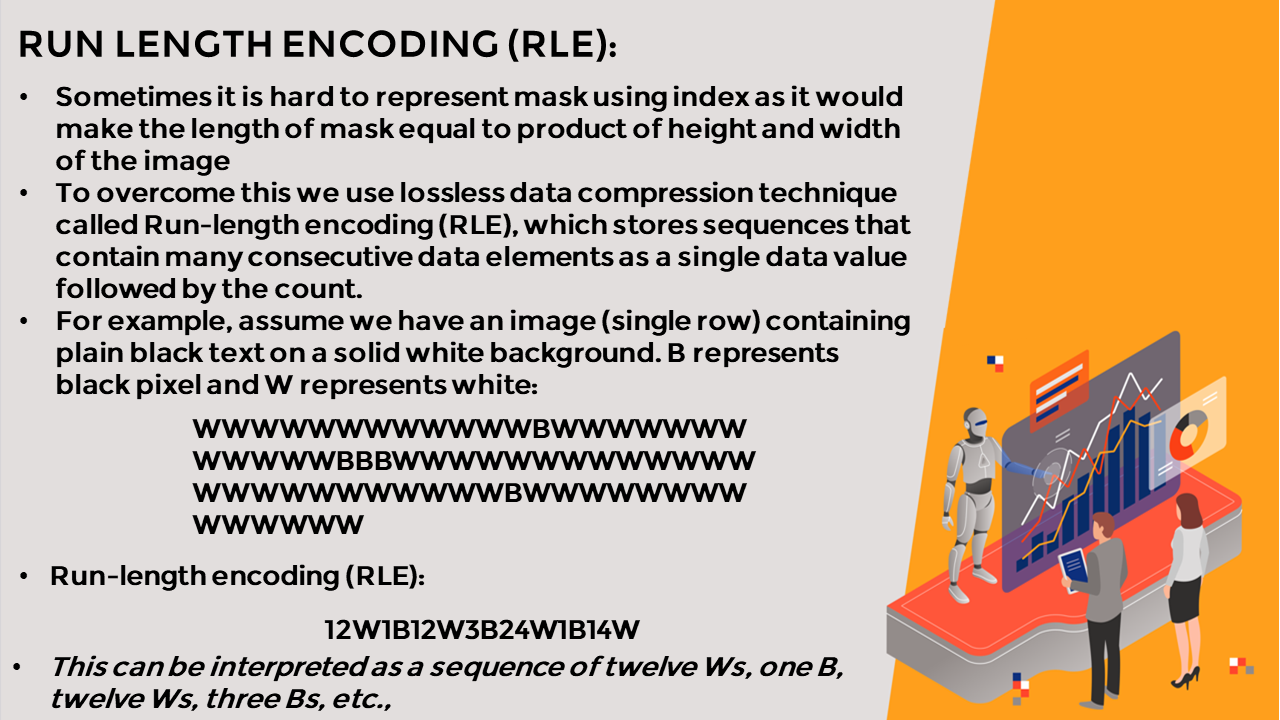

In [4]:
# data containing defect images with segmentation mask 
defect_class_mask_df = pd.read_csv(r'C:\Users\mani2\Documents\Data Science For Business\datasets\Maintenance_data\train.csv')

In [5]:
# data containing defective and non defective images
all_images_df = pd.read_csv(r'C:\Users\mani2\Documents\Data Science For Business\datasets\Maintenance_data\defect_and_no_defect.csv')

In [6]:
defect_class_mask_df

ImageId  ClassId  \
0     d2291de5c.jpg        1   
1     78416c3d0.jpg        3   
2     2283f2183.jpg        3   
3     f0dc068a8.jpg        3   
4     00d639396.jpg        3   
...             ...      ...   
5743  c12842f5e.jpg        3   
5744  2222a03b3.jpg        3   
5745  b43ea2c01.jpg        1   
5746  1bc37a6f4.jpg        3   
5747  f4413e172.jpg        3   

                                          EncodedPixels  
0     147963 3 148213 9 148461 18 148711 24 148965 2...  
1     54365 3 54621 7 54877 10 55133 12 55388 14 556...  
2     201217 43 201473 128 201729 213 201985 5086 20...  
3     159207 26 159412 77 159617 128 159822 179 1600...  
4     229356 17 229595 34 229850 36 230105 37 230360...  
...                                                 ...  
5743  88 23 342 29 596 34 850 39 1105 44 1361 46 161...  
5744  63332 4 63587 11 63841 20 64096 27 64351 35 64...  
5745  185024 7 185279 11 185535 12 185790 13 186045 ...  
5746  303867 1 304122 3 304376 6 304613 3 304630 9 3...  
5747  254911 3 255165 8 255419 12 255672 18 255926 2...  

[5748 rows x 3 columns]

In [7]:
all_images_df

ImageID  label
0      0002cc93b.jpg      1
1      0007a71bf.jpg      1
2      000a4bcdd.jpg      1
3      000f6bf48.jpg      1
4      0014fce06.jpg      1
...              ...    ...
12992  0482ee1d6.jpg      0
12993  04802a6c2.jpg      0
12994  03ae2bc91.jpg      0
12995  04238d7e3.jpg      0
12996  023353d24.jpg      0

[12997 rows x 2 columns]

### TASK-3: VISUALIZE AND EXPLORE DATASET

In [8]:
defect_class_mask_df['mask'] = defect_class_mask_df['ClassId'].map(lambda x: 1)

In [9]:
defect_class_mask_df.head(50)

ImageId  ClassId                                      EncodedPixels  \
0   d2291de5c.jpg        1  147963 3 148213 9 148461 18 148711 24 148965 2...   
1   78416c3d0.jpg        3  54365 3 54621 7 54877 10 55133 12 55388 14 556...   
2   2283f2183.jpg        3  201217 43 201473 128 201729 213 201985 5086 20...   
3   f0dc068a8.jpg        3  159207 26 159412 77 159617 128 159822 179 1600...   
4   00d639396.jpg        3  229356 17 229595 34 229850 36 230105 37 230360...   
5   17d02873a.jpg        3  254980 43 255236 127 255492 211 255748 253 256...   
6   47b5ab1bd.jpg        3  128976 8 129230 12 129484 16 129739 23 129995 ...   
7   a6ecee828.jpg        3  179011 27 179126 73 179259 39 179375 80 179497...   
8   11aaf18e2.jpg        3  303235 2 303489 7 303743 9 303997 11 304181 2 ...   
9   cdf669a1f.jpg        4  310246 11 310499 25 310753 28 311007 31 311262...   
10  fb9558035.jpg        4  159233 1 159489 2 159745 4 160001 5 160257 6 1...   
11  9fac588ab.jpg        3  68321 32 68513 96 68706 159 68930 191 69186 19...   
12  83d9b39c8.jpg        3  175089 15 175313 47 175538 78 175762 110 17598...   
13  749407e33.jpg        3  15704 3 15960 8 16216 13 16471 19 16727 23 169...   
14  e2bdd4236.jpg        3  17490 175 17746 175 18002 175 18258 175 18514 ...   
15  8bab4626b.jpg        3  37390 2 37644 5 37898 7 38151 11 38405 13 3865...   
16  3bde297da.jpg        3  154381 5 154635 17 154889 27 155143 36 155397 ...   
17  ff5483763.jpg        3  168785 7 169034 20 169284 33 169533 46 169779 ...   
18  a369c5c1f.jpg        3  18358 11 18606 32 18854 53 19102 73 19225 6 19...   
19  d62e553a8.jpg        3  11453 1 11709 2 11964 4 12220 5 12475 7 12731 ...   
20  ceccb1eef.jpg        1  361364 18 361613 42 361862 55 362112 67 362337...   
21  eda5114ee.jpg        3  38877 2 39129 6 39381 10 39633 14 39885 18 401...   
22  23c450c03.jpg        1  9251 24 9505 29 9759 32 10013 36 10267 39 1032...   
23  ab6afa374.jpg        3  65986 39 66165 116 66344 193 66561 232 66817 2...   
24  a0906d0b3.jpg        4  213842 5 214096 9 214351 11 214605 15 214860 1...   
25  5562229c3.jpg        3  22966 17 23189 49 23412 82 23636 113 23859 145...   
26  2365be47a.jpg        3  31096 3 31352 7 31608 12 31863 17 32119 21 323...   
27  737ae5c95.jpg        4  50890 4 51146 6 51401 8 51657 9 51912 11 52048...   
28  f89ce1e24.jpg        3  325112 9 325352 25 325592 41 325832 57 326071 ...   
29  a239718e1.jpg        3  322214 4 322470 12 322726 20 322982 28 323238 ...   
30  2694c98fb.jpg        3  212692 11 212928 31 213164 51 213400 71 213636...   
31  a9108753d.jpg        3  3244 4 3494 10 3743 18 3993 24 4245 28 4501 29...   
32  c4f5ebbb2.jpg        4  229758 5 230006 13 230254 21 230502 29 230750 ...   
33  75361926d.jpg        4  144404 7 144652 17 144906 20 145160 24 145414 ...   
34  fc8cb11db.jpg        1  271869 4 272115 14 272358 27 272601 40 272845 ...   
35  9f054c54f.jpg        1  191060 15 191309 24 191563 29 191818 32 191889...   
36  faea44200.jpg        3  308123 102 308379 102 308635 102 308891 102 30...   
37  9b72243dc.jpg        3  207915 9 208167 28 208385 2 208420 44 208641 6...   
38  10bbf7cb3.jpg        3  324770 1 325024 5 325278 8 325533 11 325787 14...   
39  d1cd969d5.jpg        3  307684 6 307916 7 307937 11 308167 13 308191 1...   
40  1082cfe08.jpg        4  240140 9 240395 27 240650 46 240905 64 241160 ...   
41  927be944d.jpg        1  26369 15 26625 30 26881 30 27137 30 27393 31 2...   
42  0518e79e9.jpg        3  154369 38 154625 42 154881 46 155137 50 155393...   
43  64934ac51.jpg        3  357377 28 357633 83 357889 130 358145 169 3584...   
44  26b0e74fe.jpg        3  156299 6 156545 16 156791 25 157037 35 157283 ...   
45  7b2257638.jpg        3  77828 64 78084 190 78340 253 78596 253 78852 2...   
46  975f12b62.jpg        3  185857 11 186113 31 186369 51 186625 72 186881...   
47  92932546c.jpg        3  53236 13 53468 37 53700 61 53931 86 54163 110 ...   
48  464a009f9.jpg        3  81550 10 8179

In [10]:
defect_class_mask_df

ImageId  ClassId  \
0     d2291de5c.jpg        1   
1     78416c3d0.jpg        3   
2     2283f2183.jpg        3   
3     f0dc068a8.jpg        3   
4     00d639396.jpg        3   
...             ...      ...   
5743  c12842f5e.jpg        3   
5744  2222a03b3.jpg        3   
5745  b43ea2c01.jpg        1   
5746  1bc37a6f4.jpg        3   
5747  f4413e172.jpg        3   

                                          EncodedPixels  mask  
0     147963 3 148213 9 148461 18 148711 24 148965 2...     1  
1     54365 3 54621 7 54877 10 55133 12 55388 14 556...     1  
2     201217 43 201473 128 201729 213 201985 5086 20...     1  
3     159207 26 159412 77 159617 128 159822 179 1600...     1  
4     229356 17 229595 34 229850 36 230105 37 230360...     1  
...                                                 ...   ...  
5743  88 23 342 29 596 34 850 39 1105 44 1361 46 161...     1  
5744  63332 4 63587 11 63841 20 64096 27 64351 35 64...     1  
5745  185024 7 185279 11 185535 12 185790 13 186045 ...     1  
5746  303867 1 304122 3 304376 6 304613 3 304630 9 3...     1  
5747  254911 3 255165 8 255419 12 255672 18 255926 2...     1  

[5748 rows x 4 columns]

In [11]:
defect_class_mask_df.columns

Index(['ImageId', 'ClassId', 'EncodedPixels', 'mask'], dtype='object')

In [12]:
defect_class_mask_df['ClassId'] = defect_class_mask_df['ClassId'].astype(str)

In [13]:
defect_class_mask_df.dtypes

ImageId          object
ClassId          object
EncodedPixels    object
mask              int64
dtype: object

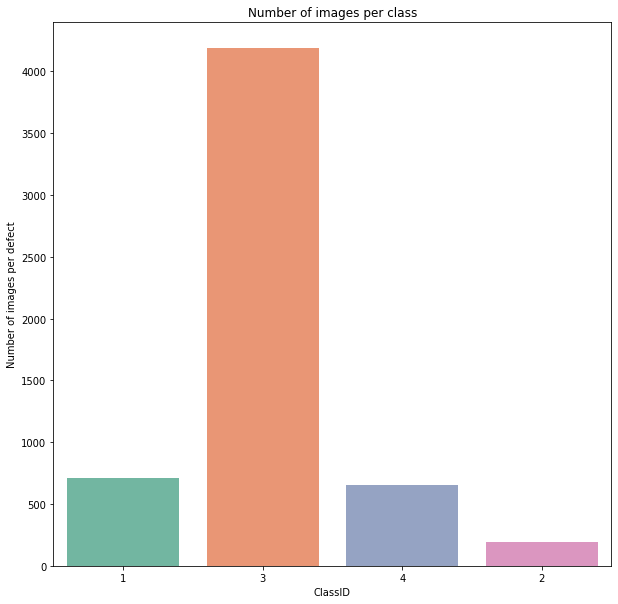

In [14]:
plt.figure(figsize=(10, 10))
sns.countplot(x='ClassId', hue= 'ClassId', legend= False, data=defect_class_mask_df, palette='Set2')
plt.xlabel('ClassID')
plt.ylabel('Number of images per defect')
plt.title('Number of images per class')
plt.show()

#### Some images are classified with more than one defect, let's explore this futher:
- we have one image with 3 types of defects 
- we have 272 images with 2 types of defects
- we have 5201 images with 1 type of defect

### Some images are classified with more than one defect, let's explore this futher
- we have one image with 3 types of defects 
- we have 272 images with 2 types of defects
- we have 5201 images with 1 type of defect

In [15]:
defect_type = defect_class_mask_df.groupby(['ImageId'])['mask'].sum()

In [16]:
defect_type

ImageId
0002cc93b.jpg    1
0007a71bf.jpg    1
000a4bcdd.jpg    1
000f6bf48.jpg    1
0014fce06.jpg    1
                ..
ffcf72ecf.jpg    1
fff02e9c5.jpg    1
fffe98443.jpg    1
ffff4eaa8.jpg    1
ffffd67df.jpg    1
Name: mask, Length: 5474, dtype: int64

In [17]:
defect_type.value_counts()

mask
1    5201
2     272
3       1
Name: count, dtype: int64

Text(0.5, 1.0, 'Number of defects in image')

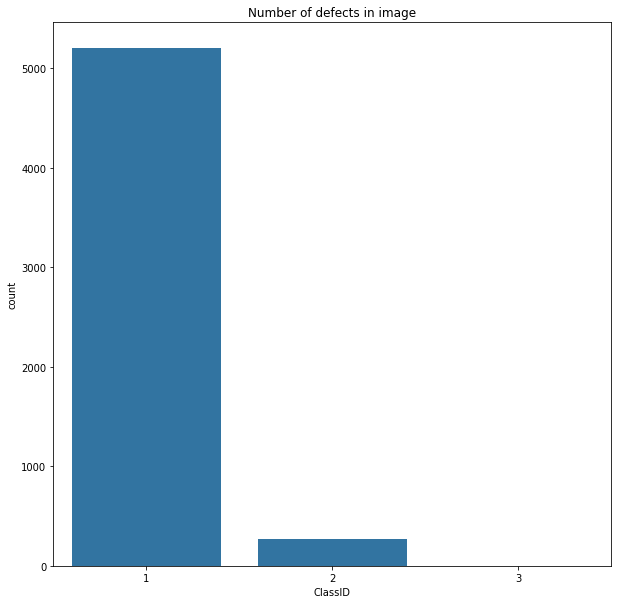

In [18]:
plt.figure(figsize=(10,10))
sns.barplot(x = defect_type.value_counts().index, y = defect_type.value_counts())
plt.xlabel('ClassID')
plt.title('Number of defects in image')

In [19]:
defect_class_mask_df.shape

(5748, 4)

In [20]:
all_images_df.shape

(12997, 2)

In [21]:
# Let's count defective and non defective images
all_images_df.label.value_counts()

label
1    7095
0    5902
Name: count, dtype: int64

Text(0.5, 1.0, 'Defect and non-defect images')

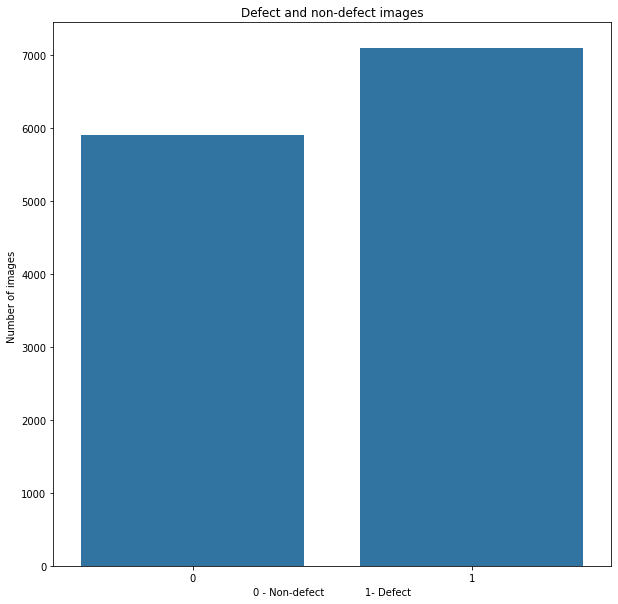

In [22]:
plt.figure(figsize=(10,10))
sns.barplot(x = all_images_df.label.value_counts().index, y = all_images_df.label.value_counts() )
plt.ylabel('Number of images ')
plt.xlabel('0 - Non-defect             1- Defect')
plt.title('Defect and non-defect images')

- Visualize images with defects along with their corresponding labels

In [23]:
# Images are 256 x 1600
# from google.colab.patches import cv2_imshow
train_dir = r'C:\Users\mani2\Documents\Data Science For Business\datasets\Maintenance_data\train_images'

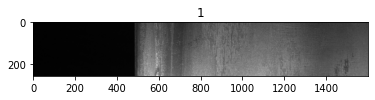

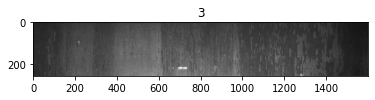

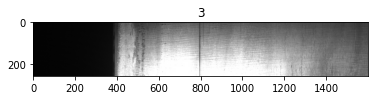

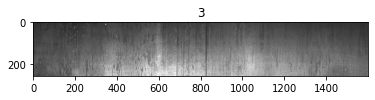

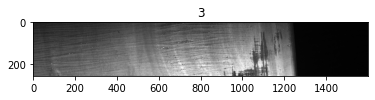

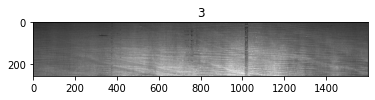

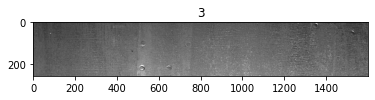

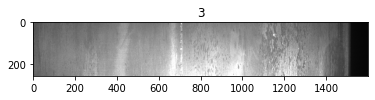

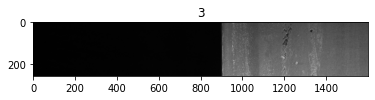

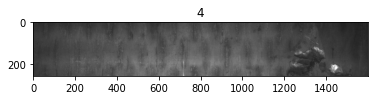

In [24]:
for i in range(10):
     # Specify the path to the images given their image ID
    img = io.imread(os.path.join(train_dir, defect_class_mask_df.ImageId[i]))
    plt.figure()
    plt.title(defect_class_mask_df.ClassId[i])
    plt.imshow(img)

- Utilities file contains the code for rle2mask, mask2rle, custom loss function and custom data generator
- since the data provided for segmentation is in RLE format (run length encoded), we will be using the following function to convert the RLE to mask. 
- we can convert the mask back again to RLE to assess model performance (accuracy).
- Code source for these function came from: https://www.kaggle.com/paulorzp/rle-functions-run-lenght-encode-decode

In [25]:
# command in colab: change your path accordingly if running via google colab
# %cd /content/drive/My Drive/Colab Notebooks/Data Science for Business/Maintenance Department 

In [26]:
%cd r'C:\Users\mani2\Documents\Data Science For Business\datasets\Maintenance_data\

[WinError 123] The filename, directory name, or volume label syntax is incorrect: "r'C:\\Users\\mani2\\Documents\\Data Science For Business\\datasets\\Maintenance_data\\"
C:\Users\mani2\Documents\Data Science For Business\notebooks


In [27]:
# Add the path to the directory where your utilities.py is located
sys.path.append(r'C:\Users\mani2\Documents\Data Science For Business\datasets\Maintenance_data')

In [28]:
from utilities import rle2mask , mask2rle
train_dir = r'C:\Users\mani2\Documents\Data Science For Business\datasets\Maintenance_data\train_images'

In [29]:
defect_class_mask_df

ImageId ClassId  \
0     d2291de5c.jpg       1   
1     78416c3d0.jpg       3   
2     2283f2183.jpg       3   
3     f0dc068a8.jpg       3   
4     00d639396.jpg       3   
...             ...     ...   
5743  c12842f5e.jpg       3   
5744  2222a03b3.jpg       3   
5745  b43ea2c01.jpg       1   
5746  1bc37a6f4.jpg       3   
5747  f4413e172.jpg       3   

                                          EncodedPixels  mask  
0     147963 3 148213 9 148461 18 148711 24 148965 2...     1  
1     54365 3 54621 7 54877 10 55133 12 55388 14 556...     1  
2     201217 43 201473 128 201729 213 201985 5086 20...     1  
3     159207 26 159412 77 159617 128 159822 179 1600...     1  
4     229356 17 229595 34 229850 36 230105 37 230360...     1  
...                                                 ...   ...  
5743  88 23 342 29 596 34 850 39 1105 44 1361 46 161...     1  
5744  63332 4 63587 11 63841 20 64096 27 64351 35 64...     1  
5745  185024 7 185279 11 185535 12 185790 13 186045 ...     1  
5746  303867 1 304122 3 304376 6 304613 3 304630 9 3...     1  
5747  254911 3 255165 8 255419 12 255672 18 255926 2...     1  

[5748 rows x 4 columns]

In [30]:
# Let's try to use the rle2mask on a sample image 
image_index = 20 #20 30
mask = rle2mask(defect_class_mask_df.EncodedPixels[image_index], img.shape[0], img.shape[1])
mask.shape

(256, 1600)

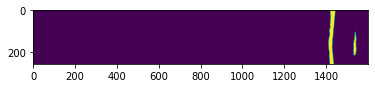

In [31]:
# Let's show the mask
plt.imshow(mask)

(256, 1600, 3)

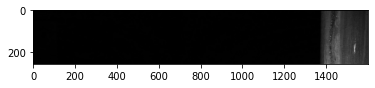

In [32]:
img = io.imread(os.path.join(train_dir, defect_class_mask_df.ImageId[image_index]))
plt.imshow(img)
img.shape

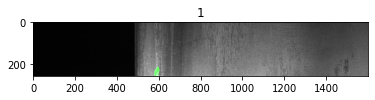

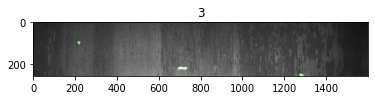

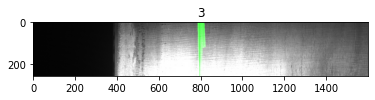

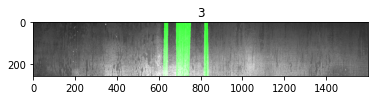

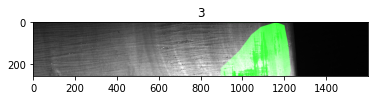

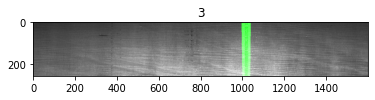

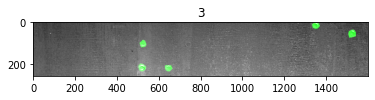

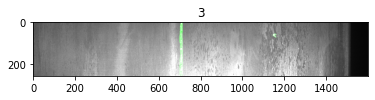

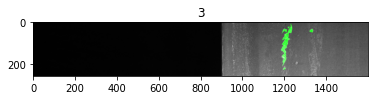

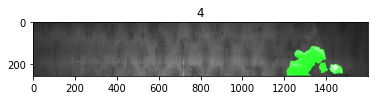

In [33]:
for i in range(10):  
    # Read the images using opencv and converting to rgb format
    img = io.imread(os.path.join(train_dir, defect_class_mask_df.ImageId[i]))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    # Get the mask for the image from rle
    mask = rle2mask(defect_class_mask_df.EncodedPixels[i], img.shape[0], img.shape[1])

    # Let's color the pixels with values = 1 
    img[mask == 1,1] = 255
    plt.figure()
    plt.imshow(img)
    plt.title(defect_class_mask_df.ClassId[i])

### TASK-4: UNDERSTAND THE THEORY AND INTUITION BEHIND CONVOLUTIONAL NEURAL NETWORKS, RESNETS, AND TRANSFER LEARNING

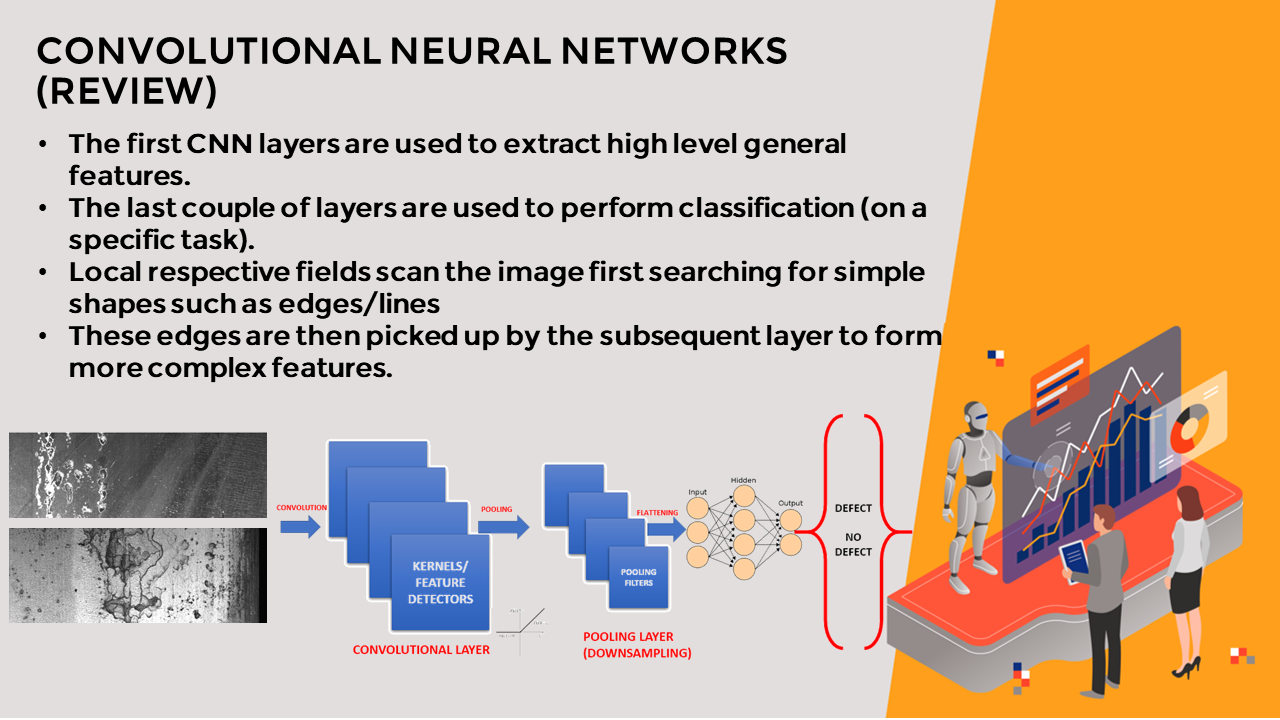

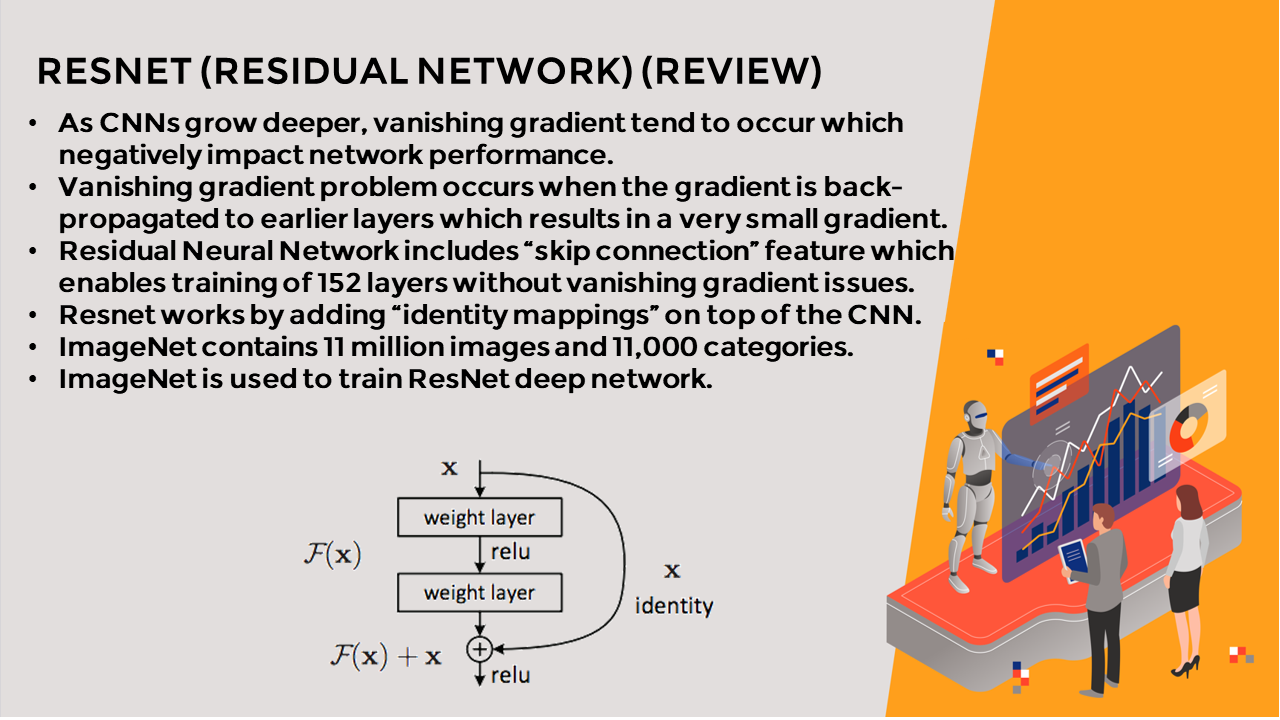

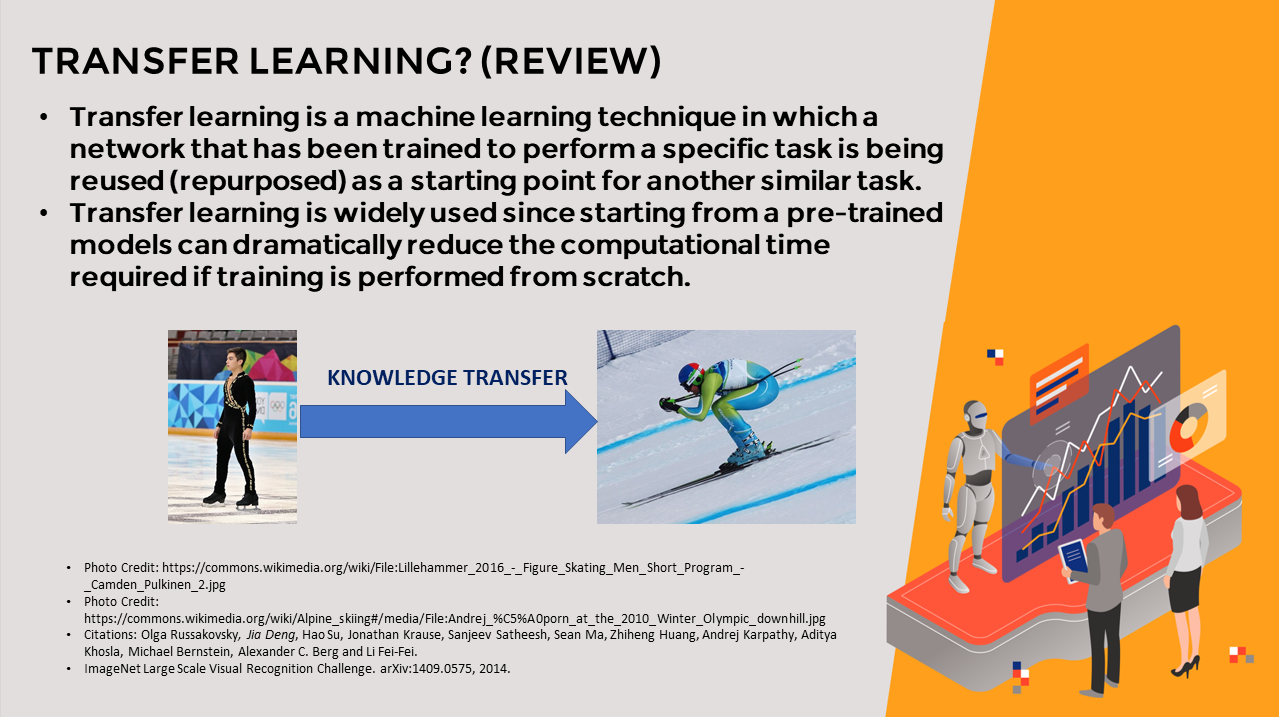

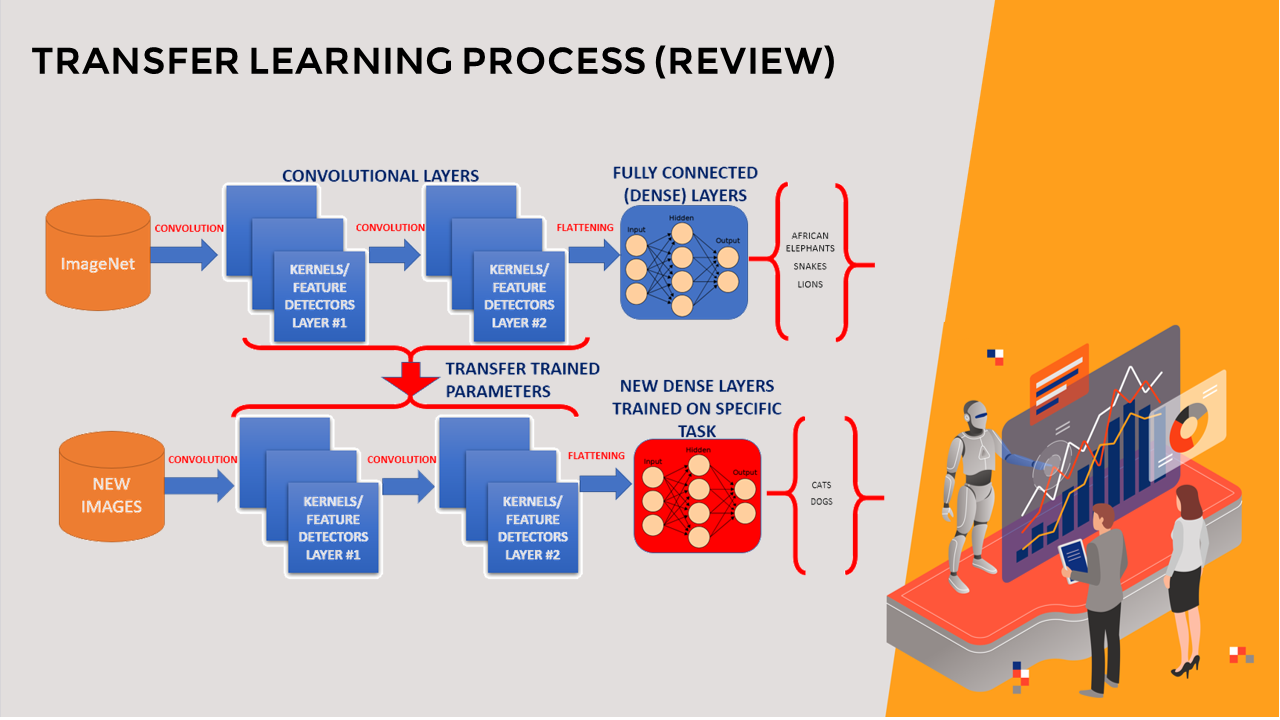

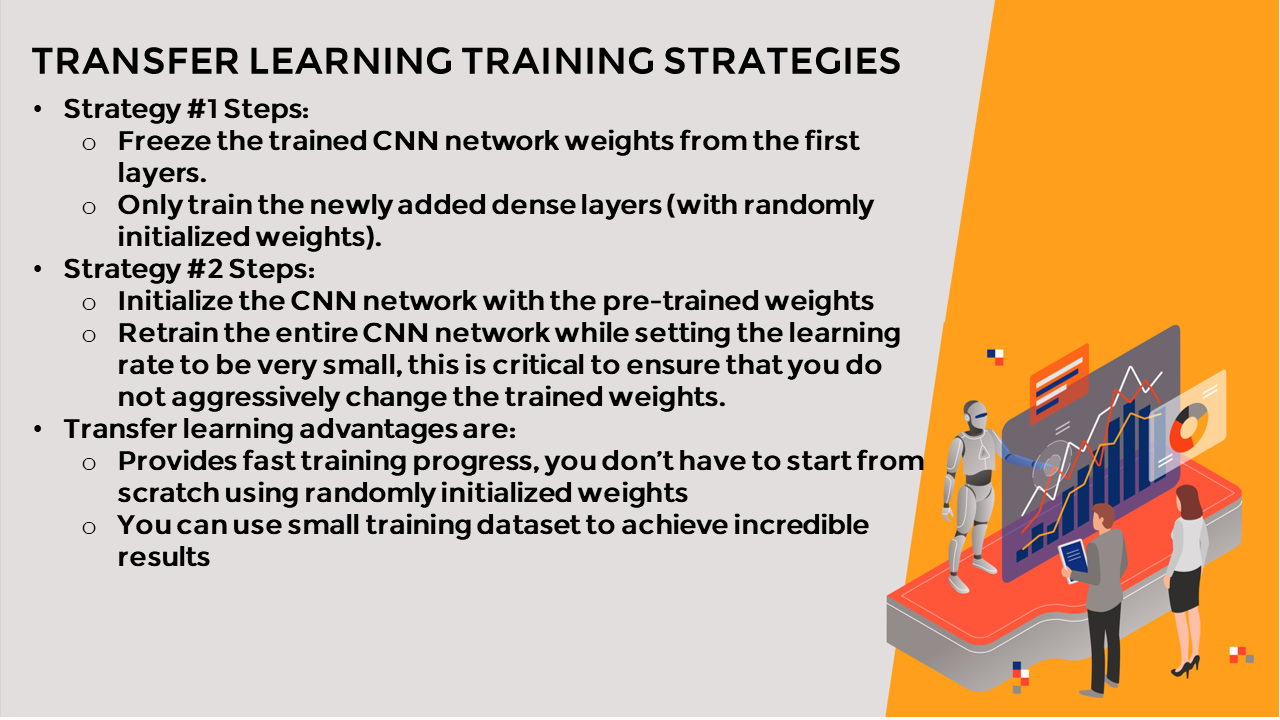

### TASK-5: BUILD AND TRAIN A DEEP LEARNING MODEL TO DETECT WHETHER A DEFECT IS PRESENT IN AN IMAGE OR NOT

In [34]:
all_images_df

ImageID  label
0      0002cc93b.jpg      1
1      0007a71bf.jpg      1
2      000a4bcdd.jpg      1
3      000f6bf48.jpg      1
4      0014fce06.jpg      1
...              ...    ...
12992  0482ee1d6.jpg      0
12993  04802a6c2.jpg      0
12994  03ae2bc91.jpg      0
12995  04238d7e3.jpg      0
12996  023353d24.jpg      0

[12997 rows x 2 columns]

In [35]:
# split the data (defective and non defective) into training and testing 
from sklearn.model_selection import train_test_split
train, test = train_test_split(all_images_df, test_size=0.15)

In [36]:
train.shape

(11047, 2)

In [37]:
test.shape

(1950, 2)

In [38]:
train_dir = r'C:\Users\mani2\Documents\Data Science For Business\datasets\Maintenance_data\train_images'

#### create a image generator for the training and validation dataset
- we will divide the data to training, validation and testing
- Training = 9390 
- validation = 1657 
- testing = 1950 

In [39]:
from keras.preprocessing.image import ImageDataGenerator

In [40]:
# Create a data generator which scales the data from 0 to 1 and makes validation split of 0.15
datagen = ImageDataGenerator(rescale=1./255., validation_split = 0.15)

train_generator = datagen.flow_from_dataframe(
dataframe = train,
directory = train_dir,
x_col = "ImageID",
y_col = "label",
subset = "training",
batch_size = 16,
shuffle = True,
class_mode = "other",
target_size = (256, 256))


valid_generator = datagen.flow_from_dataframe(
dataframe = train,
directory = train_dir,
x_col = "ImageID",
y_col = "label",
subset = "validation",
batch_size = 16,
shuffle = True,
class_mode = "other",
target_size = (256, 256))

Found 9390 validated image filenames.
Found 1657 validated image filenames.


In [41]:
# Create a data generator for test images
test_datagen = ImageDataGenerator(rescale=1./255.)

test_generator = test_datagen.flow_from_dataframe(
dataframe = test,
directory = train_dir,
x_col = "ImageID",
y_col = None,
batch_size = 16,
shuffle = False,
class_mode = None,
target_size = (256, 256))

Found 1950 validated image filenames.


In [42]:
basemodel = ResNet50(weights = 'imagenet', include_top = False, input_tensor = Input(shape=(256,256,3)))

In [43]:
basemodel.summary()

Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 256, 256, 3)]        0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 262, 262, 3)          0         ['input_1[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, 128, 128, 64)         9472      ['conv1_pad[0][0]']           
                                                                                                  
 conv1_bn (BatchNormalizati  (None, 128, 128, 64)         256       ['conv1_conv[0][0]']          
 on)                                                                                       

                                                                                                  
 conv2_block3_1_conv (Conv2  (None, 64, 64, 64)           16448     ['conv2_block2_out[0][0]']    
 D)                                                                                               
                                                                                                  
 conv2_block3_1_bn (BatchNo  (None, 64, 64, 64)           256       ['conv2_block3_1_conv[0][0]'] 
 rmalization)                                                                                     
                                                                                                  
 conv2_block3_1_relu (Activ  (None, 64, 64, 64)           0         ['conv2_block3_1_bn[0][0]']   
 ation)                                                                                           
                                                                                                  
 conv2_blo

 ation)                                                                                           
                                                                                                  
 conv3_block2_3_conv (Conv2  (None, 32, 32, 512)          66048     ['conv3_block2_2_relu[0][0]'] 
 D)                                                                                               
                                                                                                  
 conv3_block2_3_bn (BatchNo  (None, 32, 32, 512)          2048      ['conv3_block2_3_conv[0][0]'] 
 rmalization)                                                                                     
                                                                                                  
 conv3_block2_add (Add)      (None, 32, 32, 512)          0         ['conv3_block1_out[0][0]',    
                                                                     'conv3_block2_3_bn[0][0]']   
          

 conv4_block1_2_conv (Conv2  (None, 16, 16, 256)          590080    ['conv4_block1_1_relu[0][0]'] 
 D)                                                                                               
                                                                                                  
 conv4_block1_2_bn (BatchNo  (None, 16, 16, 256)          1024      ['conv4_block1_2_conv[0][0]'] 
 rmalization)                                                                                     
                                                                                                  
 conv4_block1_2_relu (Activ  (None, 16, 16, 256)          0         ['conv4_block1_2_bn[0][0]']   
 ation)                                                                                           
                                                                                                  
 conv4_block1_0_conv (Conv2  (None, 16, 16, 1024)         525312    ['conv3_block4_out[0][0]']    
 D)       

                                                                                                  
 conv4_block3_out (Activati  (None, 16, 16, 1024)         0         ['conv4_block3_add[0][0]']    
 on)                                                                                              
                                                                                                  
 conv4_block4_1_conv (Conv2  (None, 16, 16, 256)          262400    ['conv4_block3_out[0][0]']    
 D)                                                                                               
                                                                                                  
 conv4_block4_1_bn (BatchNo  (None, 16, 16, 256)          1024      ['conv4_block4_1_conv[0][0]'] 
 rmalization)                                                                                     
                                                                                                  
 conv4_blo

 D)                                                                                               
                                                                                                  
 conv4_block6_3_bn (BatchNo  (None, 16, 16, 1024)         4096      ['conv4_block6_3_conv[0][0]'] 
 rmalization)                                                                                     
                                                                                                  
 conv4_block6_add (Add)      (None, 16, 16, 1024)         0         ['conv4_block5_out[0][0]',    
                                                                     'conv4_block6_3_bn[0][0]']   
                                                                                                  
 conv4_block6_out (Activati  (None, 16, 16, 1024)         0         ['conv4_block6_add[0][0]']    
 on)                                                                                              
          

 conv5_block3_1_relu (Activ  (None, 8, 8, 512)            0         ['conv5_block3_1_bn[0][0]']   
 ation)                                                                                           
                                                                                                  
 conv5_block3_2_conv (Conv2  (None, 8, 8, 512)            2359808   ['conv5_block3_1_relu[0][0]'] 
 D)                                                                                               
                                                                                                  
 conv5_block3_2_bn (BatchNo  (None, 8, 8, 512)            2048      ['conv5_block3_2_conv[0][0]'] 
 rmalization)                                                                                     
                                                                                                  
 conv5_block3_2_relu (Activ  (None, 8, 8, 512)            0         ['conv5_block3_2_bn[0][0]']   
 ation)   

In [44]:
# freeze the model weights
for layer in basemodel.layers:
    layers.trainable = False

In [45]:
headmodel = basemodel.output
headmodel = AveragePooling2D(pool_size = (4,4))(headmodel)
headmodel = Flatten(name= 'flatten')(headmodel)
headmodel = Dense(256, activation = "relu")(headmodel)
headmodel = Dropout(0.3)(headmodel)
headmodel = Dense(1, activation = 'sigmoid')(headmodel)

model = Model(inputs = basemodel.input, outputs = headmodel)

In [46]:
model.compile(loss = 'binary_crossentropy', optimizer='Nadam', metrics= ["accuracy"])

In [47]:
# use early stopping to exit training if validation loss is not decreasing even after certain epochs (patience)
earlystopping = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=20)

# save the best model with least validation loss
checkpointer = ModelCheckpoint(filepath="resnet-weights.hdf5", verbose=1, save_best_only=True)

In [48]:
# (WARNING TAKES LONG TIME (~90 mins)!) : This takes alot of time, hence i am using a pre-trained model
history = model.fit_generator(train_generator, steps_per_epoch= train_generator.n // 16, epochs = 40, validation_data= valid_generator, validation_steps= valid_generator.n // 16, callbacks=[checkpointer, earlystopping])

In [49]:
# save the trained model architecture for future use
model_json = model.to_json()
with open(r"C:\Users\mani2\Documents\Data Science For Business\datasets\Maintenance_data\resnet-classifier-model.json","w") as json_file:
    json_file.write(model_json)

### TASK-6: ASSESS TRAINED MODEL PERFORMANCE

In [50]:
with open(r'C:\Users\mani2\Documents\Data Science For Business\datasets\Maintenance_data\resnet-classifier-model.json', 'r') as json_file:
    json_savedModel= json_file.read()

In [51]:
# load the model  
model = tf.keras.models.model_from_json(json_savedModel)
model.load_weights(r'C:\Users\mani2\Documents\Data Science For Business\datasets\Maintenance_data\weights.hdf5')
model.compile(loss = 'binary_crossentropy', optimizer='Nadam', metrics= ["accuracy"])

In [52]:
# Make prediction (WARNING TAKES LONG TIME (~10 mins)!)
from keras.preprocessing.image import ImageDataGenerator

test_predict = model.predict(test_generator, steps = test_generator.n // 16, verbose =1)

121/121 [==============================] - 122s 998ms/step


In [53]:
test_predict

array([[9.9494565e-01],
       [9.8585916e-01],
       [7.7419536e-04],
       ...,
       [5.3671123e-03],
       [9.9984121e-01],
       [5.3983690e-10]], dtype=float32)

- Since we have used sigmoid activation at the end, our result would contain continuous values from 0 to 1.
- The network is initially used to classify whether the image has defect or not
- Then these images (defective) is passed through the segmentation network to get the localization and type of defect. 
- Let's choose 0.01, to make sure, that we omit images from passing through the segmentation network only we are highly certain that it has no defect and if we are not confident, we can pass this image through the segmentation network

In [54]:
predict = []

for i in test_predict:
    if i < 0.01: #0.5
        predict.append(0)
    else:
        predict.append(1)

predict = np.asarray(predict)

In [55]:
len(predict)

1936

In [56]:
# since we have used test generator, it limited the images to 1936, due to batch size
original = np.asarray(test.label)[:1936]
len(original)

1936

In [57]:
# Find the accuracy of the model
from sklearn.metrics import accuracy_score

accuracy = accuracy_score(original, predict)
accuracy

0.8853305785123967

<Axes: >

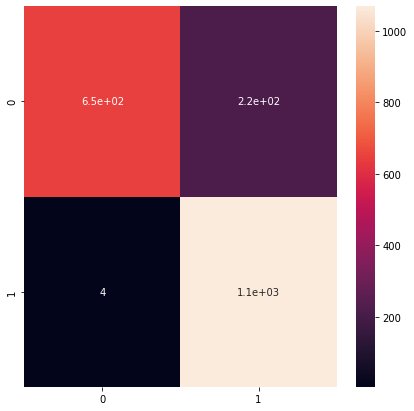

In [58]:
# Plot the confusion matrix
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(original, predict)
plt.figure(figsize = (7,7))
sns.heatmap(cm, annot=True)

In [59]:
# Print the classification report
from sklearn.metrics import classification_report

report = classification_report(original,predict, labels = [0,1])
print(report)

              precision    recall  f1-score   support

           0       0.99      0.75      0.85       864
           1       0.83      1.00      0.91      1072

    accuracy                           0.89      1936
   macro avg       0.91      0.87      0.88      1936
weighted avg       0.90      0.89      0.88      1936



### TASK-7: UNDERSTAND THE THEORY AND INTUITION BEHIND RESUNET (SEGMENTATION)

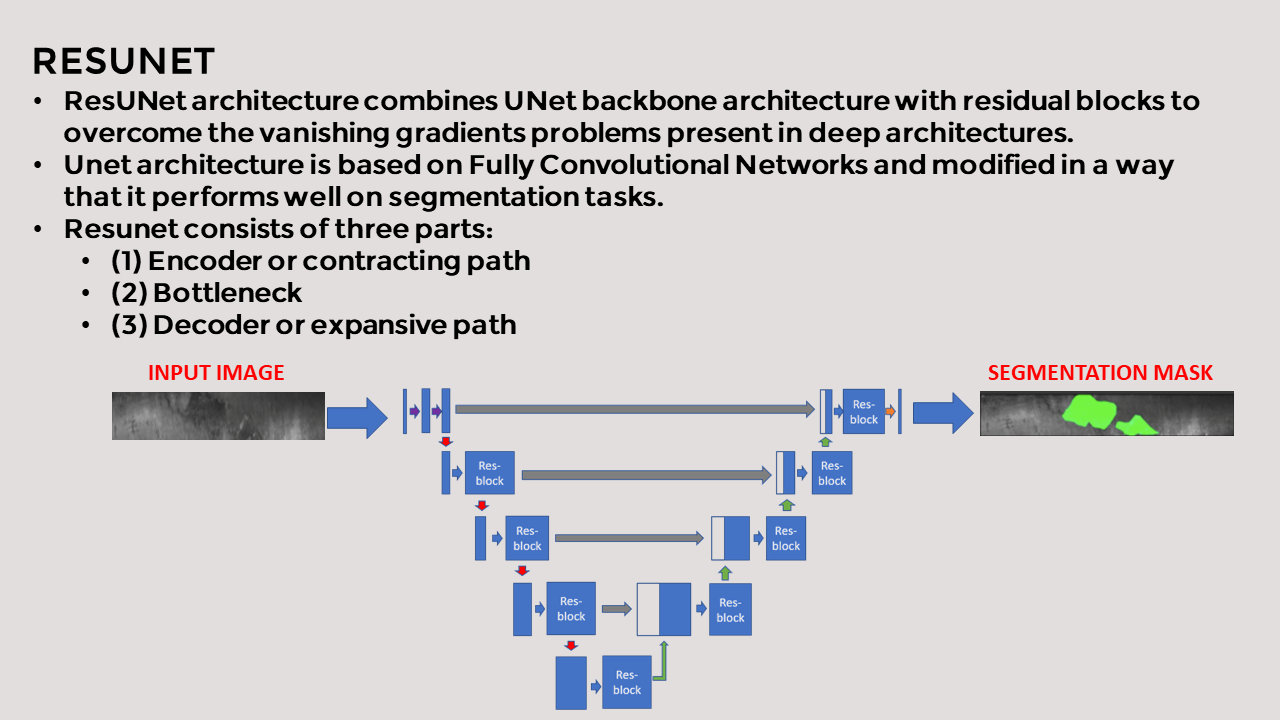

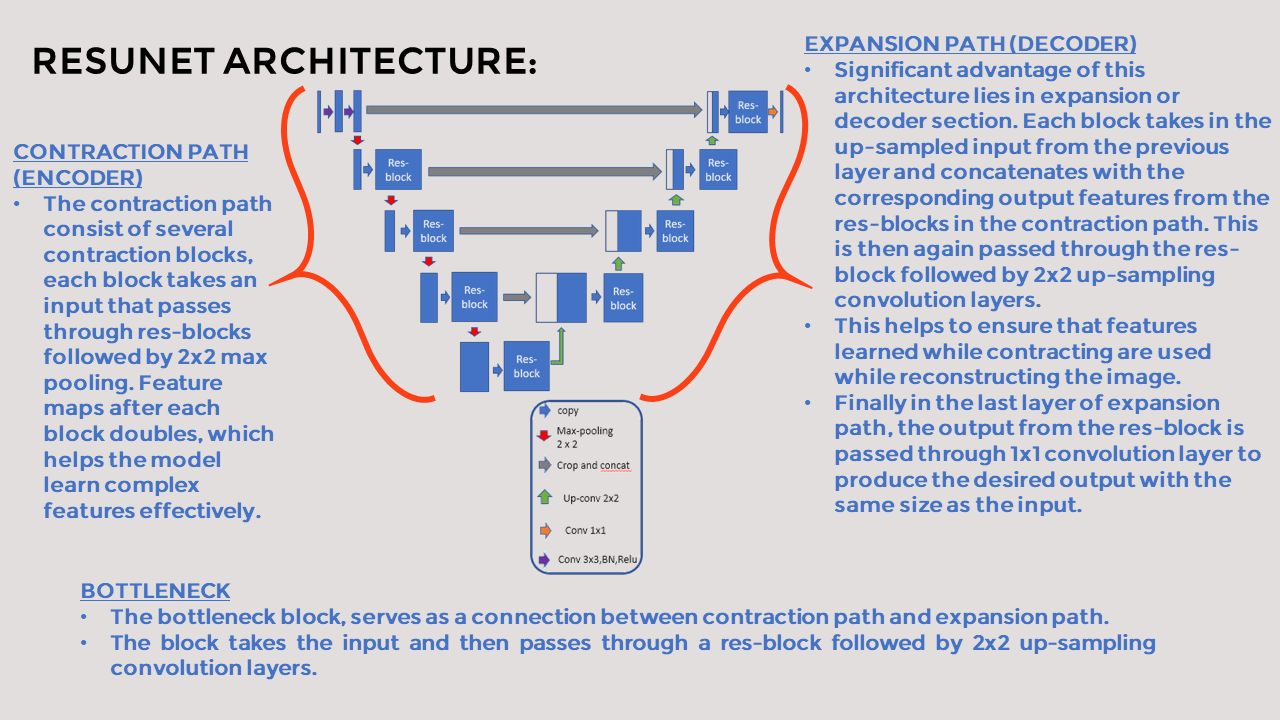

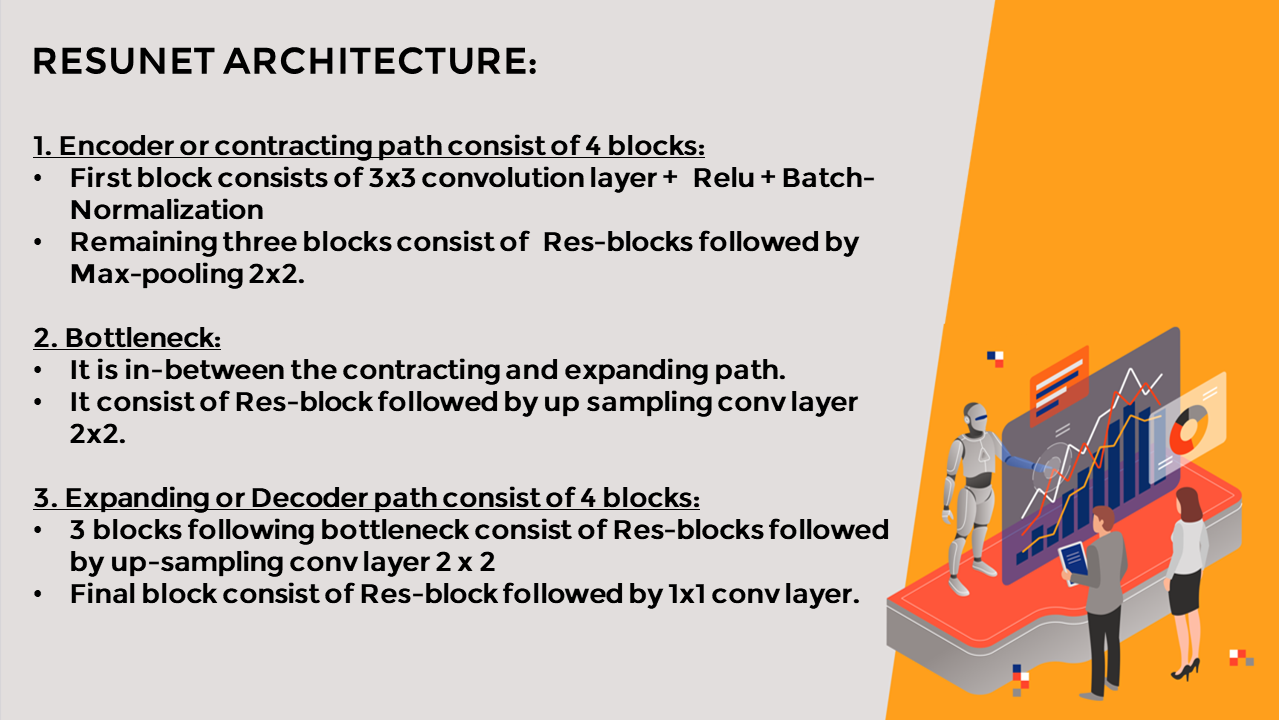

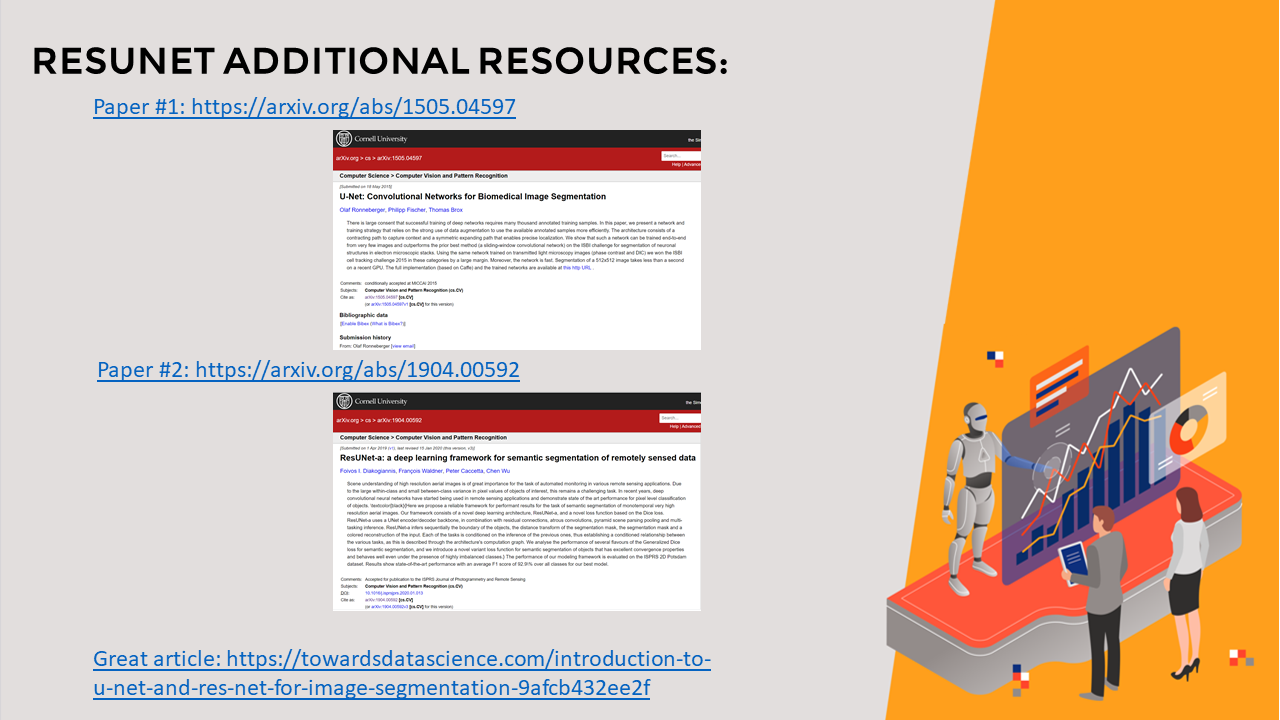

### TASK-8: BUILD A RESUNET SEGMENTATION MODEL

In [60]:
# spliting the data into train and test data
from sklearn.model_selection import train_test_split

X_train, X_val = train_test_split(defect_class_mask_df, test_size=0.2)

In [61]:
#creating separate list for imageId, classId and rle to pass into the generator

train_ids = list(X_train.ImageId)
train_class = list(X_train.ClassId)
train_rle = list(X_train.EncodedPixels)

val_ids = list(X_val.ImageId)
val_class = list(X_val.ClassId)
val_rle = list(X_val.EncodedPixels)

In [62]:
from utilities import DataGenerator

#creating image generators
training_generator = DataGenerator(train_ids,train_class, train_rle, train_dir)
validation_generator = DataGenerator(val_ids,val_class,val_rle, train_dir)

In [63]:
def resblock(X, f):
    # making a copy of input
    X_copy = X

    # main path
    # Read more about he_normal: https://medium.com/@prateekvishnu/xavier-and-he-normal-he-et-al-initialization-8e3d7a087528

    X = Conv2D(f, kernel_size = (1,1), strides = (1,1), kernel_initializer ='he_normal')(X)
    X = BatchNormalization()(X)
    X = Activation('relu')(X) 

    X = Conv2D(f, kernel_size = (3,3), strides =(1,1), padding = 'same', kernel_initializer ='he_normal')(X)
    X = BatchNormalization()(X)

    # Short path
    # Read more here: https://towardsdatascience.com/understanding-and-coding-a-resnet-in-keras-446d7ff84d33

    X_copy = Conv2D(f, kernel_size = (1,1), strides =(1,1), kernel_initializer ='he_normal')(X_copy)
    X_copy = BatchNormalization()(X_copy)

    # Adding the output from main path and short path together

    X = Add()([X,X_copy])
    X = Activation('relu')(X)

    return X

In [64]:
# function to upscale and concatnating the values passsed
def upsample_concat(x, skip):
    x = UpSampling2D((2,2))(x)
    merge = Concatenate()([x, skip])

    return merge

In [65]:
input_shape = (256,256,1)

#Input tensor shape
X_input = Input(input_shape)

#Stage 1
conv1_in = Conv2D(16,3,activation= 'relu', padding = 'same', kernel_initializer ='he_normal')(X_input)
conv1_in = BatchNormalization()(conv1_in)
conv1_in = Conv2D(16,3,activation= 'relu', padding = 'same', kernel_initializer ='he_normal')(conv1_in)
conv1_in = BatchNormalization()(conv1_in)
pool_1 = MaxPool2D(pool_size = (2,2))(conv1_in)

#Stage 2
conv2_in = resblock(pool_1, 32)
pool_2 = MaxPool2D(pool_size = (2,2))(conv2_in)

#Stage 3
conv3_in = resblock(pool_2, 64)
pool_3 = MaxPool2D(pool_size = (2,2))(conv3_in)

#Stage 4
conv4_in = resblock(pool_3, 128)
pool_4 = MaxPool2D(pool_size = (2,2))(conv4_in)

#Stage 5
conv5_in = resblock(pool_4, 256)

#Upscale stage 1
up_1 = upsample_concat(conv5_in, conv4_in)
up_1 = resblock(up_1, 128)

#Upscale stage 2
up_2 = upsample_concat(up_1, conv3_in)
up_2 = resblock(up_2, 64)

#Upscale stage 3
up_3 = upsample_concat(up_2, conv2_in)
up_3 = resblock(up_3, 32)

#Upscale stage 4
up_4 = upsample_concat(up_3, conv1_in)
up_4 = resblock(up_4, 16)

#Final Output
output = Conv2D(4, (1,1), padding = "same", activation = "sigmoid")(up_4)

model_seg = Model(inputs = X_input, outputs = output )


#### Loss function:
- We need a custom loss function to train this ResUNet.So, we have used the loss function as it is from https://github.com/nabsabraham/focal-tversky-unet/blob/master/losses.py

- @article{focal-unet, title={A novel Focal Tversky loss function with improved Attention U-Net for lesion segmentation}, author={Abraham, Nabila and Khan, Naimul Mefraz}, journal={arXiv preprint arXiv:1810.07842}, year={2018} }

In [66]:
%cd  r'C:\Users\mani2\Documents\Data Science For Business\datasets\Maintenance_data\'

[WinError 123] The filename, directory name, or volume label syntax is incorrect: "r'C:\\Users\\mani2\\Documents\\Data Science For Business\\datasets\\Maintenance_data\\'"
C:\Users\mani2\Documents\Data Science For Business\notebooks


In [67]:
# Add the path to the directory where your utilities.py is located
sys.path.append(r'C:\Users\mani2\Documents\Data Science For Business\datasets\Maintenance_data')

In [68]:
from utilities import focal_tversky, tversky_loss, tversky

In [69]:
adam = tf.keras.optimizers.Adam(lr = 0.05, epsilon = 0.1)
model_seg.compile(optimizer = adam, loss = focal_tversky, metrics = [tversky])

In [70]:
# using early stopping to exit training if validation loss is not decreasing even after certain epochs (patience)
earlystopping = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=20)

# save the best model with lower validation loss
checkpointer = ModelCheckpoint(filepath="resunet-segmentation-weights.hdf5", verbose=1, save_best_only=True)

In [71]:
history = model_seg.fit_generator(training_generator, epochs = 40, validation_data= validation_generator, callbacks=[checkpointer, earlystopping])

In [72]:
# save the model for future use
model_json = model_seg.to_json()
with open(r"C:\Users\mani2\Documents\Data Science For Business\datasets\Maintenance_data\resunet-segmentation-model.json","w") as json_file:
    json_file.write(model_json)

### TASK-9: ASSESS TRAINED SEGMENTATION MODEL PERFORMANCE

In [73]:
from utilities import focal_tversky, tversky_loss, tversky, prediction

with open(r'C:\Users\mani2\Documents\Data Science For Business\datasets\Maintenance_data\resunet-segmentation-model.json', 'r') as json_file:
    json_savedModel= json_file.read()

# load the model  
model_seg = tf.keras.models.model_from_json(json_savedModel)
model_seg.load_weights(r'C:\Users\mani2\Documents\Data Science For Business\datasets\Maintenance_data\weights_seg.hdf5')
adam = tf.keras.optimizers.Adam(lr = 0.05, epsilon = 0.1)
model_seg.compile(optimizer = adam, loss = focal_tversky, metrics = [tversky])

In [74]:
# data containing test images for segmentation task 
test_df = pd.read_csv(r'C:\Users\mani2\Documents\Data Science For Business\datasets\Maintenance_data\test.csv')

In [75]:
test_df

ImageId  ClassId                                      EncodedPixels
0    0ca915b9f.jpg        3  188383 3 188637 5 188892 6 189148 5 189403 6 1...
1    7773445b7.jpg        3  75789 33 76045 97 76300 135 76556 143 76811 15...
2    5e0744d4b.jpg        3  120323 91 120579 182 120835 181 121091 181 121...
3    6ccde604d.jpg        3  295905 32 296098 95 296290 159 296483 222 2967...
4    16aabaf79.jpg        1  352959 24 353211 28 353465 31 353719 33 353973...
..             ...      ...                                                ...
633  a4334d7da.jpg        4  11829 7 12073 20 12317 32 12566 40 12821 41 13...
634  418e47222.jpg        3  46340 43 46596 127 46852 211 47108 253 47364 2...
635  817a545aa.jpg        3  206529 64 206657 4518 211201 179 211457 128 21...
636  caad490a5.jpg        3  59631 10 59867 30 60103 50 60339 69 60585 79 6...
637  a5e9195b6.jpg        3  321 51 424 43 577 51 641 82 833 51 897 82 1089...

[638 rows x 3 columns]

In [76]:
test_df.ImageId

0      0ca915b9f.jpg
1      7773445b7.jpg
2      5e0744d4b.jpg
3      6ccde604d.jpg
4      16aabaf79.jpg
           ...      
633    a4334d7da.jpg
634    418e47222.jpg
635    817a545aa.jpg
636    caad490a5.jpg
637    a5e9195b6.jpg
Name: ImageId, Length: 638, dtype: object

In [77]:
from utilities import prediction # Note that you need to modify directory inside prediction function in utilities

In [79]:
# make prediction
image_id, defect_type, mask = prediction(test_df, model, model_seg)

1/1 [==============================] - 0s 81ms/step


1/1 [==============================] - 0s 74ms/step


1/1 [==============================] - 0s 138ms/step


1/1 [==============================] - 0s 85ms/step


1/1 [==============================] - 0s 76ms/step


1/1 [==============================] - 0s 86ms/step


1/1 [==============================] - 0s 171ms/step


1/1 [==============================] - 0s 109ms/step


1/1 [==============================] - 0s 137ms/step


In [80]:
# create a dataframe for the result
df_pred= pd.DataFrame({'ImageId': image_id,'EncodedPixels': mask,'ClassId': defect_type})
df_pred.head()

ImageId                                      EncodedPixels  ClassId
0  0ca915b9f.jpg  151421 1 151423 2 151677 1 151679 2 151933 1 1...        3
1  7773445b7.jpg  72927 2 73183 2 73439 2 73695 2 73951 2 74207 ...        3
2  5e0744d4b.jpg  116095 2 116351 2 116607 2 116863 2 117119 2 1...        3
3  6ccde604d.jpg  290305 4 290561 4 290817 4 291073 4 291329 4 2...        3
4  16aabaf79.jpg  352937 24 353193 24 353449 24 353705 24 353961...        3

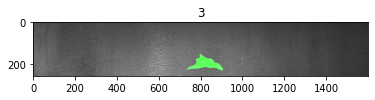

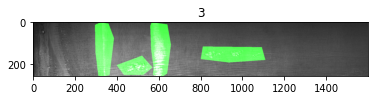

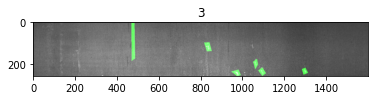

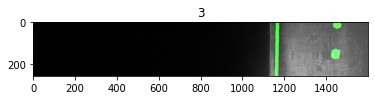

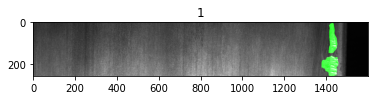

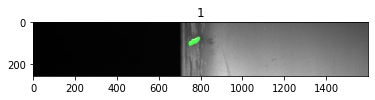

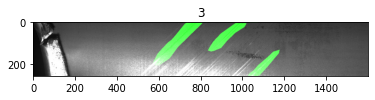

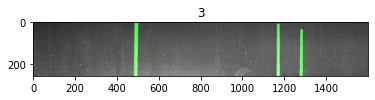

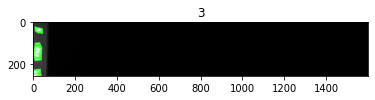

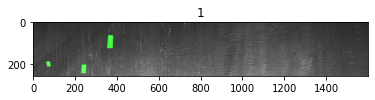

In [81]:
# Let's show the images along with their original (ground truth) masks
for i in range(10):
  # read the images using opencv and convert them to rgb format
    img = io.imread(os.path.join(train_dir,test_df.ImageId[i]))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    # Obtain mask for the image from rle
    mask = rle2mask(test_df.EncodedPixels[i],img.shape[0],img.shape[1])

    img[mask == 1,1] = 255
    plt.figure()
    plt.title(test_df.ClassId[i])
    plt.imshow(img)

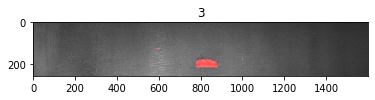

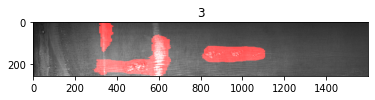

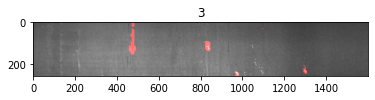

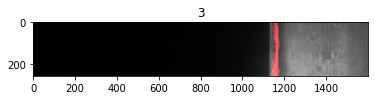

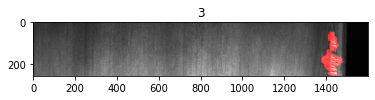

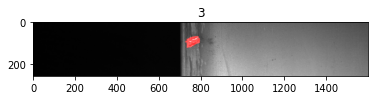

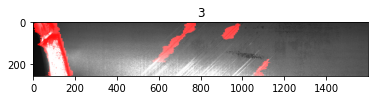

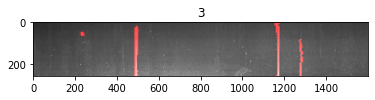

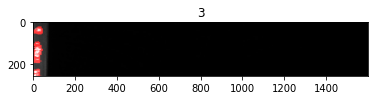

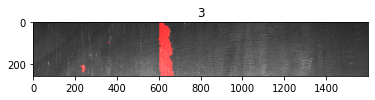

In [85]:
# visualize the results (model predictions)
directory = r"C:\Users\mani2\Documents\Data Science For Business\datasets\Maintenance_data\train_images"

for i in range(10):
    # read the images using opencv and convert to rgb format
    img = io.imread(os.path.join(directory,df_pred.ImageId[i]))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    # get the mask for the image from rle
    mask = rle2mask(df_pred.EncodedPixels[i],img.shape[0],img.shape[1])
  
    img[mask == 1,0] = 255
    plt.figure()
    plt.title(df_pred.ClassId[i])
    plt.imshow(img)

### End